# Lab 9 - Python Code
### Conie O'Malley


## Part 6: Clustering in Python: K-Means, DBSCAN, and Hierarchical



### Importing Libraries and Loading Data


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud
import umap
import warnings
warnings.filterwarnings('ignore')

In [27]:
# python data load
categories = ['comp.graphics', 'rec.sport.baseball', 'sci.space', 'talk.politics.guns']
newsgroups = fetch_20newsgroups(categories=categories, remove=('headers', 'footers', 'quotes'))

### Creating TF-IDF Matrix

In [28]:

# Create TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=5000,
stop_words='english',
max_df=0.95,
min_df=2)
tfidf_matrix = vectorizer.fit_transform(newsgroups.data)

### Dimensionality Reduction for Visualization

In [29]:
# Using TruncatedSVD (LSA) first
n_components = 100
lsa = TruncatedSVD(n_components=n_components)
doc_vectors_lsa = lsa.fit_transform(tfidf_matrix)

# Further reduce to 2D using UMAP for visualization
reducer = umap.UMAP(random_state=42)
doc_vectors_2d = reducer.fit_transform(doc_vectors_lsa)

### Preparing for and Conducting K-means Clustering

In [30]:
def perform_kmeans_clustering(vectors, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vectors)
    # Get cluster centers
    if vectors.shape[1] > 2:
        centers_2d = reducer.transform(kmeans.cluster_centers_)
    else:
        centers_2d = kmeans.cluster_centers_
    return kmeans, cluster_labels, centers_2d

# Perform k-means clustering
kmeans_model, kmeans_labels, centers = perform_kmeans_clustering(doc_vectors_lsa)

### Visualize K-means Clusters

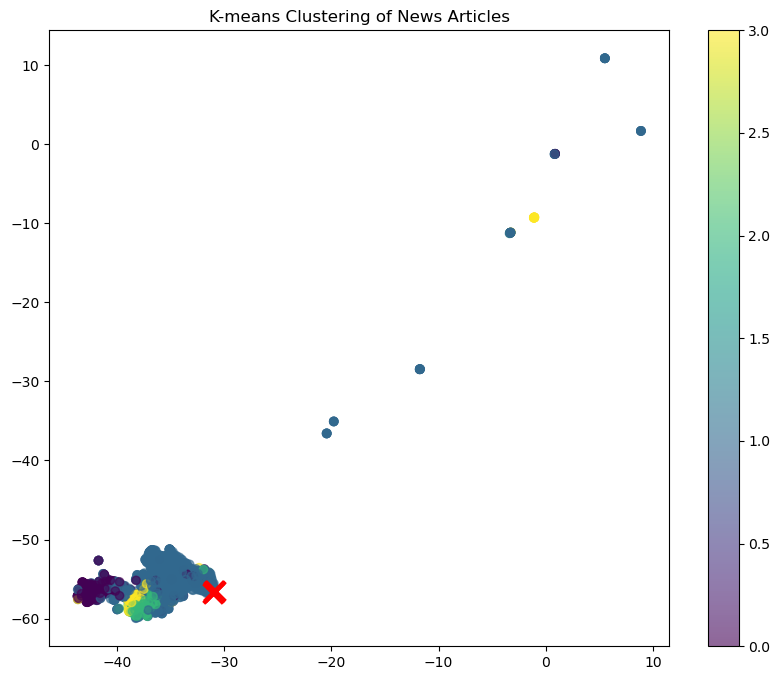

In [31]:
# k means cluster viz}
plt.figure(figsize=(10, 8))
scatter = plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1],
c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.title('K-means Clustering of News Articles')
plt.colorbar(scatter)
plt.show()


### Hierarchical Clustering in Python

In [32]:
def perform_hierarchical_clustering(vectors, n_clusters=4):
    # Perform hierarchical clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters)
    hc_labels = hc.fit_predict(vectors)
    # Create linkage matrix for dendrogram
    linkage_matrix = linkage(vectors, method='ward')
    return hc, hc_labels, linkage_matrix

# Perform hierarchical clustering
hc_model, hc_labels, linkage_matrix = perform_hierarchical_clustering(doc_vectors_lsa)

### Plot Dendrogram

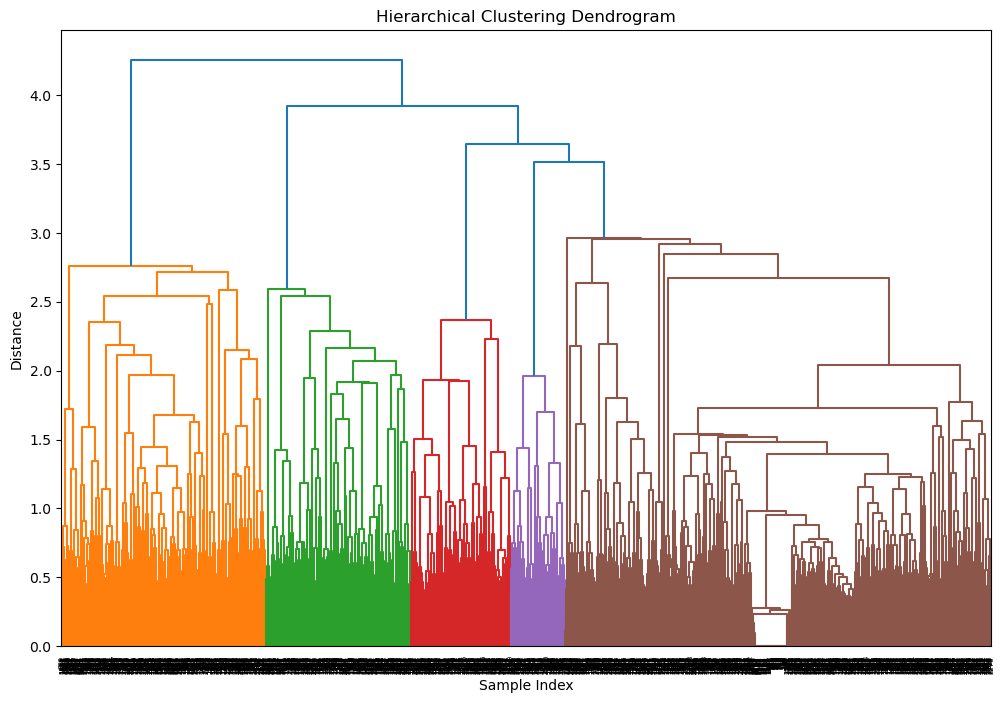

In [33]:
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

### DBSCAN Clustering

In [34]:
def perform_dbscan_clustering(vectors, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(vectors)
    return dbscan, dbscan_labels

# Perform DBSCAN clustering
dbscan_model, dbscan_labels = perform_dbscan_clustering(doc_vectors_lsa)

### Cluster Analysis and Evaluation

In [35]:
def analyze_clusters(vectors, labels, vectorizer):
    # Convert sparse matrix to dense array
    vectors_dense = vectors.toarray() if hasattr(vectors, 'todense') else vectors

    # Calculate silhouette score
    sil_score = silhouette_score(vectors_dense, labels)
    # Calculate Calinski-Harabasz score
    ch_score = calinski_harabasz_score(vectors_dense, labels)
    
    # Get top terms per cluster
    n_terms = 10
    cluster_terms = {}
    # Original feature names
    feature_names = np.array(vectorizer.get_feature_names_out())
    # For each cluster
    for cluster_id in np.unique(labels):
        if cluster_id != -1:  # Ignore noise points from DBSCAN
            # Get points in cluster
            cluster_docs = vectors[labels == cluster_id].toarray() if hasattr(vectors, 'todense') else vectors[labels == cluster_id]
            # Calculate mean tfidf scores for each term
            centroid = cluster_docs.mean(axis=0)
            # Get top terms
            top_term_indices = centroid.argsort()[-n_terms:][::-1]
            top_terms = feature_names[top_term_indices]
            cluster_terms[f'Cluster {cluster_id}'] = top_terms

    return {
        'silhouette_score': sil_score,
        'calinski_harabasz_score': ch_score,
        'top_terms': cluster_terms
    }

# Example usage
kmeans_analysis = analyze_clusters(tfidf_matrix, kmeans_labels, vectorizer)
hc_analysis = analyze_clusters(tfidf_matrix, hc_labels, vectorizer)
dbscan_analysis = analyze_clusters(tfidf_matrix, dbscan_labels, vectorizer)

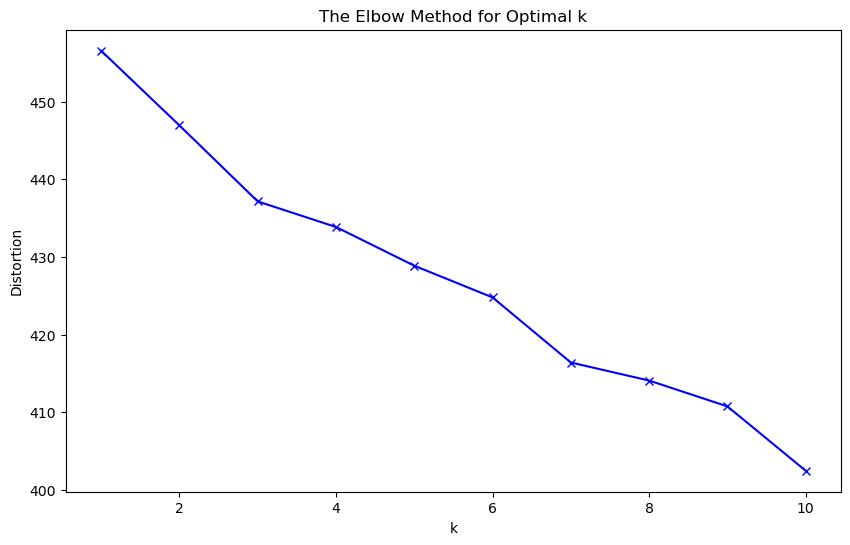

In [36]:
# Elbow Method for K-means
def plot_elbow_curve(vectors, max_k=10):
    distortions = []
    K = range(1, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(vectors)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method for Optimal k')
    plt.show()

plot_elbow_curve(doc_vectors_lsa)

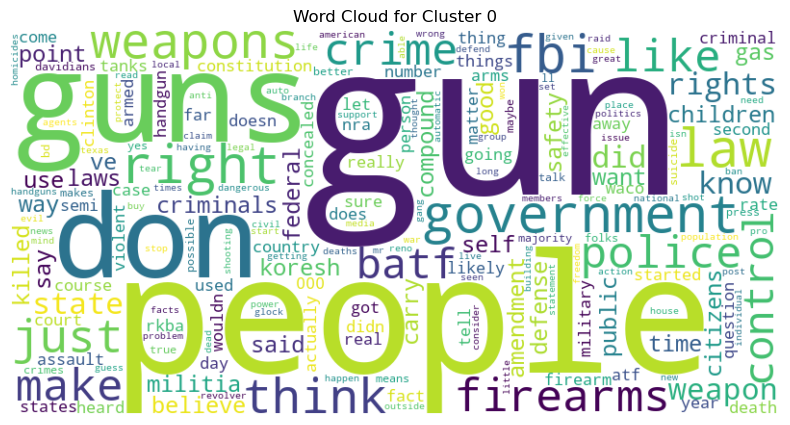

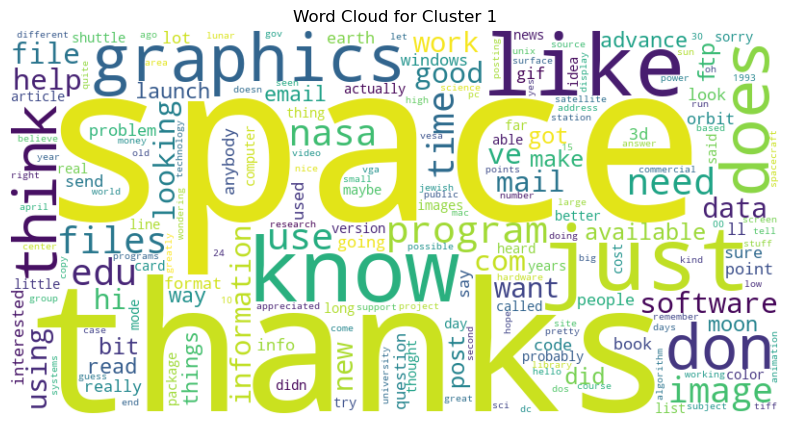

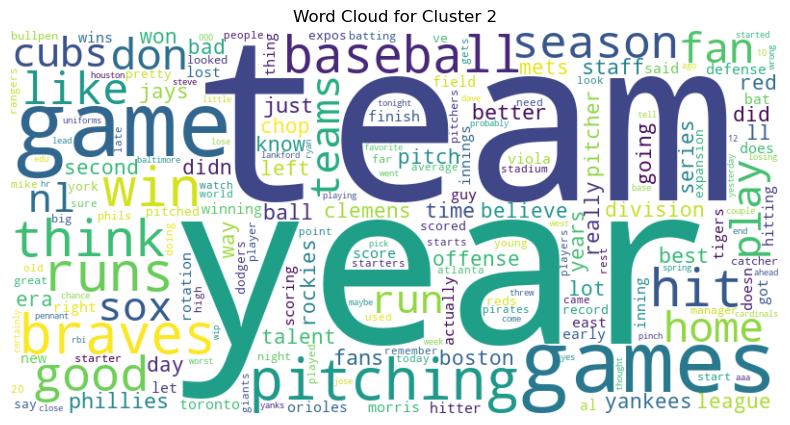

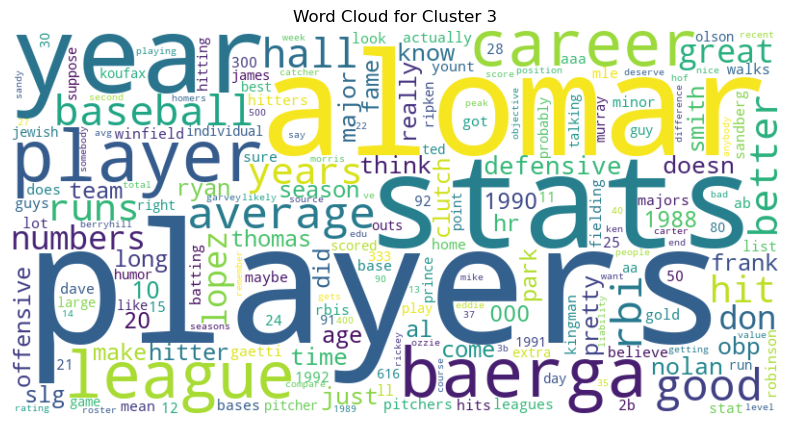

In [37]:
# Generate Word Clouds for Clusters
def generate_cluster_wordcloud(vectors, labels, vectorizer, cluster_id):
    # Get documents in cluster
    cluster_docs = vectors[labels == cluster_id]
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    # Calculate mean tfidf scores
    centroid = cluster_docs.mean(axis=0).A1 if hasattr(cluster_docs, 'todense') else cluster_docs.mean(axis=0)
    # Create word frequency dictionary
    word_freq = {feature_names[i]: centroid[i]
                 for i in range(len(feature_names))
                 if centroid[i] > 0}

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.show()

# Generate word clouds for K-means clusters
for cluster_id in np.unique(kmeans_labels):
    generate_cluster_wordcloud(tfidf_matrix, kmeans_labels, vectorizer, cluster_id)

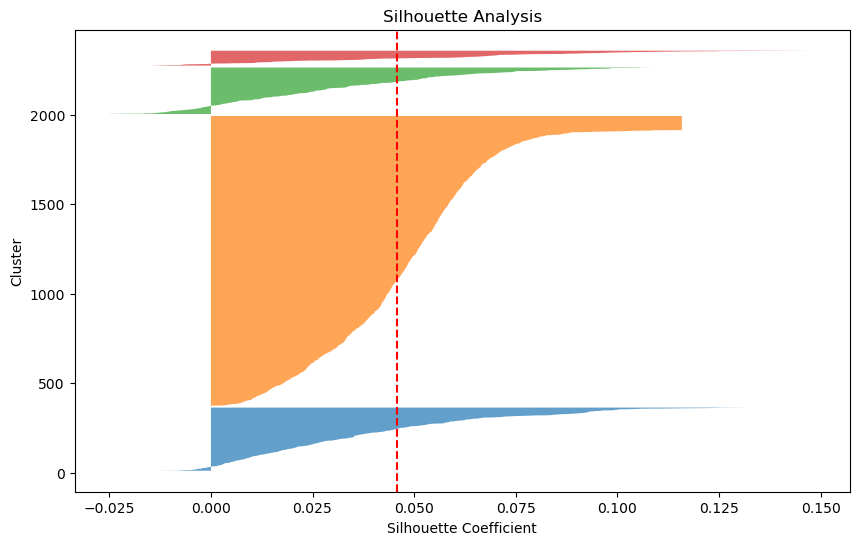

In [38]:
# Silhouette Analysis Visualization
def plot_silhouette_analysis(vectors, labels):
    plt.figure(figsize=(10, 6))
    silhouette_avg = silhouette_score(vectors, labels)
    sample_silhouette_values = silhouette_samples(vectors, labels)
    y_lower = 10
    for i in range(len(np.unique(labels))):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            alpha=0.7)
        y_lower = y_upper + 10

    plt.title("Silhouette Analysis")
    plt.xlabel("Silhouette Coefficient")
    plt.ylabel("Cluster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

# Plot silhouette analysis for K-means
from sklearn.metrics import silhouette_samples

plot_silhouette_analysis(doc_vectors_lsa, kmeans_labels)

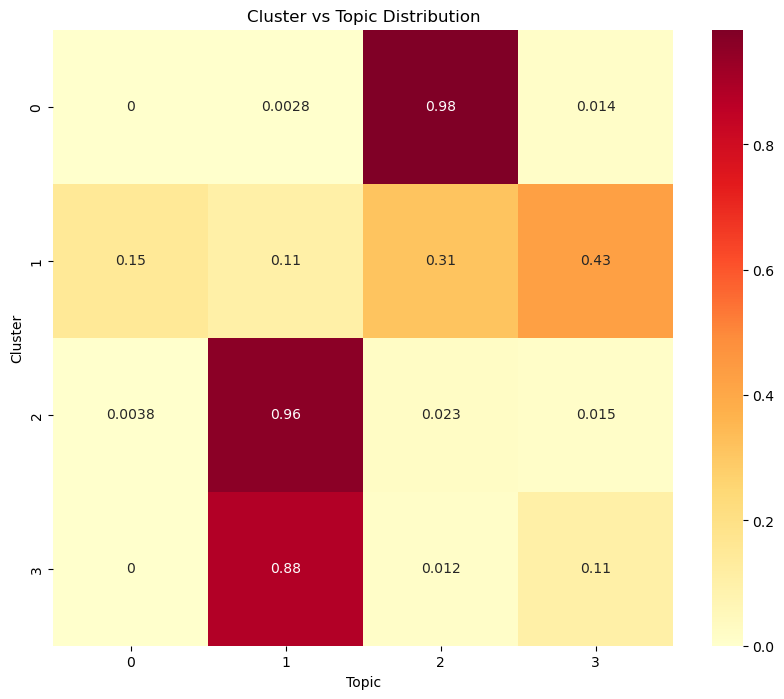

In [39]:
# Compare with Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

def compare_clustering_with_lda(vectors, cluster_labels, n_topics=4):
    # Perform LDA
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    doc_topics = lda.fit_transform(vectors)
    topic_labels = doc_topics.argmax(axis=1)

    # Create confusion matrix
    confusion_matrix = pd.crosstab(cluster_labels, topic_labels,
                                    normalize='index')

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='YlOrRd')
    plt.title('Cluster vs Topic Distribution')
    plt.xlabel('Topic')
    plt.ylabel('Cluster')
    plt.show()

# Compare K-means clusters with LDA topics
compare_clustering_with_lda(tfidf_matrix, kmeans_labels)

## Part 7: LDA Topic Modelling in Python

### Importing Libraries and Loading Data

In [40]:
# Import necessary libraries
import nltk
import matplotlib.pyplot as plt
# Download NLTK data (run this only once)
nltk.download('reuters')

# Load the Reuters dataset from NLTK
from nltk.corpus import reuters

[nltk_data] Downloading package reuters to
[nltk_data]     /Users/coniecakes/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [41]:
# Select a subset of documents for simplicity (e.g., first 100 documents)
docs = [reuters.raw(fileid) for fileid in reuters.fileids()[:100]]

### Preprocessing the Data

In [42]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Function to preprocess text
def preprocess(text):
    # Convert text to lowercase, tokenize, remove punctuation and stopwords
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

# Preprocess each document
processed_docs = [preprocess(doc) for doc in docs]

### Creating a Dictionary and Corpus

I had issues with gensim after this point - unable to render in python, but was able to render in r using reticulate.

In [ ]:
import gensim
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_docs)

# Filter out extremes to remove noise and infrequent words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Convert the dictionary to a bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

### Applying LDA Topic Modeling

In [ ]:
# Apply LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)

# Print the topics
#for index, topic in lda_model.print_topics():
#    print(f"Topic: {index} \nWords: {topic}\n")

### Visualizing the Topics

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare visualization of the topics
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Save the visualization to an HTML file
pyLDAvis.save_html(vis, 'lda_visualization.html')